# Project Analysis NoteBook
## Data Input

The datasets used in this project are available from ['The Cancer Genome Atlas' (TCGA)](www.http://cancergenome.nih.gov/) consortium.  Clinical and RNA-seq gene count data sets can be downloaded via a provided data portal, or using an R package called [TCGA2STAT](https://cran.r-project.org/web/packages/TCGA2STAT/index.html).  The R script used to download the data sets for this project are available in the local repository for this project ([GitHub link](https://github.com/CCThompson82/Prostate_metastasis/tree/master/Dataset_setup)).  If run locally, two [feather](https://github.com/wesm/feather) files will be written to the working directory, which will be read and imported with the python scripts below.

In [1]:
%run -i Dataset_cleanup/arrange_DF.py

Clinical data set imported!
Features: 21 
Patients: 499

 The following features do not provide any information: 
 ['Composite.Element.REF' 'ethnicity' 'gender' 'pathologicstage'
 'pathologyMstage' 'tumortissuesite'] 

Variables that are not known at initial diagnosis: 
 ['daystodeath' 'daystolastfollowup' 'daystopsa' 'histologicaltype'
 'numberoflymphnodes' 'pathologyTstage' 'radiationtherapy' 'residualtumor'
 'vitalstatus'] 

Variables that are known at the time of diagnosis:
 ['clinical_index' 'dateofinitialpathologicdiagnosis' 'gleasonscore'
 'pathologyNstage' 'psavalue' 'race' 'yearstobirth']


Gene Counts data set imported!
Features: 20501 
Patients: 497


Transforming gene counts to transcript per million (TPM)

Transformation Successful!

497 Gene count estimate profiles have been transformed from gene counts to transcripts per million reads (TPM)


## Data Exploration
### Clinical Information - including metastasis label
There is missing clinical data in many of the features, including what will become the outcome label ('pathologyNstage' - metastasis state).  The series **'y_all'** is the full list of pathologyNstage, where 'n1' represents metastasis, and 'n0' represents no metastasis observed to date.  Some observations have no metastasis state recorded and are represented by NaN in y_all.  These are removed for the trimmed **'y'** series.  

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

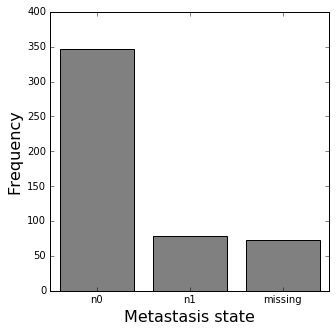

In [3]:
D = (('n0', y_all[y_all =='n0'].shape[0]), 
     ('n1', y_all[y_all =='n1'].shape[0]), 
     ('missing' , y_all[y_all.isnull()].shape[0]))
exp_fig = plt.figure(figsize=(5 , 5))
A = exp_fig.add_subplot(1,1,1)
ind = A.bar(range(0,3), height= [D[0][1], D[1][1], D[2][1]], align='center', color = 'grey')
A.set_xticks(range(0,3))
A.set_ylabel('Frequency', fontsize=16)
A.set_xlabel('Metastasis state', fontsize=16)
A.set_ylim(0,400)
A.set_xticklabels([D[0][0], D[1][0], D[2][0]])  #Must be a better way to do this as tuples (D, in this case) are not ordered?
ep = plt.show
exp_fig.savefig('Figures/Label_count.png')

### Exploratory Visualization

#### Gleason Score versus Metastasis analysis
The Gleason score is the gold-standard diagnostic test for cancer severity, but is not highly correlative with metastatic disease.  

In [4]:
clinical['gleasonscore'] = pd.to_numeric(clinical['gleasonscore'], errors= 'coerce')
clinical['gleasonscore'].isnull().any()

False

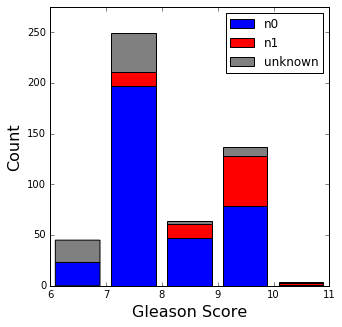

In [5]:
GS_hist = plt.figure(figsize=(5,5))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show
GS_hist.savefig('Figures/Gleason_hist.png')

It appears that no metastases are recorded in those specimens graded at a Gleason score of 6.  This represents an opportunity to replace the missing data label with the most likely pathology state, n0, to more efficiently use the small data set.  

In [6]:
"""Define the indices where gleasonscore == 6 and pathologyNstage is null"""
set(y_all[y_all.isnull()].index).intersection(list(clinical[clinical['gleasonscore'] == 6].index))

{'TCGA-2A-A8VO',
 'TCGA-2A-AAYO',
 'TCGA-CH-5738',
 'TCGA-G9-6342',
 'TCGA-G9-6347',
 'TCGA-G9-6371',
 'TCGA-G9-7509',
 'TCGA-H9-A6BX',
 'TCGA-HC-7075',
 'TCGA-HC-7077',
 'TCGA-HC-8213',
 'TCGA-HC-8259',
 'TCGA-J4-A67Q',
 'TCGA-J4-A83K',
 'TCGA-J9-A8CN',
 'TCGA-M7-A720',
 'TCGA-V1-A8WN',
 'TCGA-V1-A8WS',
 'TCGA-V1-A9OF',
 'TCGA-V1-A9OQ',
 'TCGA-V1-A9OT',
 'TCGA-XJ-A9DQ'}

In [7]:
y_all.loc[set(y_all[y_all.isnull()].index).intersection(list(clinical[clinical['gleasonscore'] == 6].index))] = 'n0'

/Users/ccthomps/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


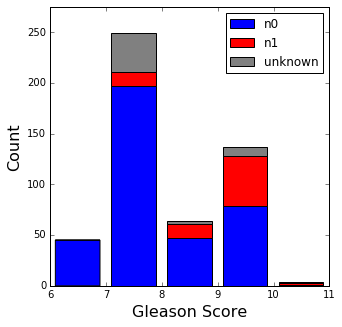

In [8]:
GS_hist = plt.figure(figsize=(5,5))
A = GS_hist.add_subplot(1,1,1)
sub = (('n1', ))

subs = [clinical.loc[y_all[y_all == 'n0'].index]['gleasonscore'],
        clinical.loc[y_all[y_all == 'n1'].index]['gleasonscore'],
        clinical.loc[y_all[y_all.isnull()].index]['gleasonscore']]

bins = [5.99, 6.99, 7.99, 8.99, 9.99, 10.99]
A.hist(subs, bins, label =['n0', 'n1', 'unknown'], color = ['blue','red','grey'], stacked = True)
A.set_ylim(0,275)
A.set_ylabel('Count', fontsize=16)
A.set_xlabel('Gleason Score', fontsize =16)
A.legend()
plt.show
GS_hist.savefig('Figures/Gleason_hist2.png')

#### Gene Activation (Gene counts) Dataset
The starting dataset, **'X_all'**, includes the transformed transcript per million (TPM) estimates for all RNA-seq profiles.  However some of the observations in this set do not have corresponding y_labels, as the clinical data set contains missing information.

Therefore X_all was trimmed to include only those observations where a finite y label exists, to yield **'X'**.  

In [9]:
print("Total observations in original dataset:",clinical.shape[0])

not_labeled = y_all[y_all.isnull()] 
y = y_all[y_all.notnull()]

print("\nObservations with metastasis label:",y.shape[0])
print("Unlabeled observations (removed:)",not_labeled.shape[0])


Total observations in original dataset: 499

Observations with metastasis label: 448
Unlabeled observations (removed:) 51


In [10]:
"""Limit X to only observations where a target label is present."""
X = X_all.loc[set(y.index).intersection(X_all.index)]  #Only observations that also have a known metastasis state are kept.
y = y.loc[set(X.index).intersection(y.index)]
print("X dimensions:",X.shape,"\ny dimensions:",y.shape)

X dimensions: (446, 20501) 
y dimensions: (446,)


In [11]:
X_no_y = X_all.loc[list(not_labeled.index)]
print("Dimensions of unlabeled dataset:",X_no_y.shape)

Dimensions of unlabeled dataset: (51, 20501)


In [12]:
X.isnull().values.any()

False

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif
K_selector = SelectKBest(f_classif, k = 'all') # using k=all here and will filter based on F-stat later.  
K = K_selector.fit(X, y)
K_df = pd.DataFrame({'Gene':X.columns, 'F_score':K.scores_})
K_df.dropna(inplace=True)

/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 1595  1815  2267  4324  4341  4342  4343  4344  4345  4346  4347  4779
  4780  4781  4782  4787  4790  4791  4794  4795  4801  4803  5259  6032
  6776  6780  6783  7445  7551  7632  7633  7634  7635  7636  7732  9275
  9277  9287  9291  9419  9421  9423  9495 10092 11101 11929 12028 12488
 12527 12593 12606 13749 13963 14015 14129 14130 14131 14132 14726 14727
 14729 15109 15111 15112 16536 16538 16539 16541 16542 16543 16545 16546
 16547 16548 16549 16550 16576 16605 16608 16648 16668 16669 16670 16671
 16672 16673 16674 16675 16676 16677 16678 16679 16680 16681 16682 16683
 16684 16685 16686 16687 16688 16689 16690 16691 16692 16693 16694 16695
 16696 16697 16698 16699 16700 16701 16702 16703 16704 16705 16706 16707
 16708 16709 16710 16711 16712 16713 16714 16715 16716 16717 16718 16720
 16721 16722 16723 16724 16725 16726 16728 16729 16730 16731 16732 

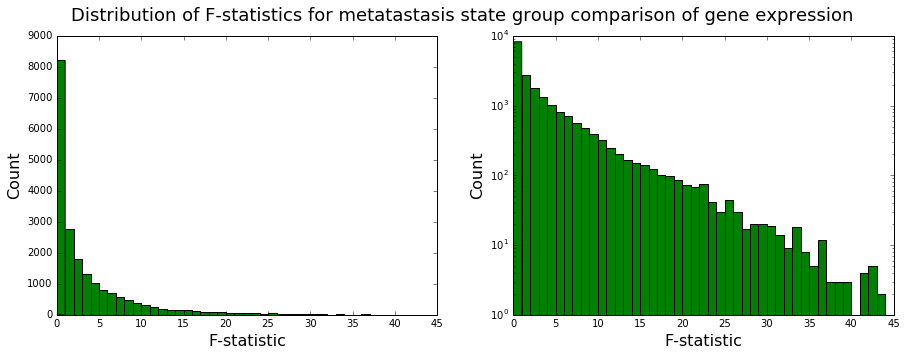

In [14]:
F_fig = plt.figure(figsize=(15,5))
A = F_fig.add_subplot(1,2,1)
A.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
#A.set_yscale('log')
A.set_ylabel('Count', fontsize=16)
A.set_xlabel("F-statistic", fontsize=16)
F_fig.suptitle("Distribution of F-statistics for metatastasis state group comparison of gene expression", fontsize = 18)
B = F_fig.add_subplot(1,2,2)
B.hist(K_df['F_score'], bins=range(0,45,1), facecolor='green')
B.set_yscale('log')
B.set_ylabel('Count', fontsize=16)
B.set_xlabel("F-statistic", fontsize=16)
#B.set_title("Distribution of F-statistics for metatastasis state group comparison of gene expression", fontsize = 18)
plt.show
F_fig.savefig("Figures/F_distribution.png")

### Benchmark 
#### Determine the Null Error / Accuracy Rates for Prediction
As the dataset is unbalanced, knowledge of the null rate - i.e. the performance measure given if a model were to predict the positive label indiscriminantly - is an important benchmark upon which to improve.  

In [15]:
from sklearn.metrics import matthews_corrcoef, fbeta_score, classification_report, log_loss
from sklearn.model_selection import cross_val_score

In [16]:
"""Scorers needed throughout code:"""
from sklearn.metrics import make_scorer
LL_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True, needs_threshold=False)
MCC_scorer = make_scorer(matthews_corrcoef, greater_is_better=True, needs_proba=False, needs_threshold=False)
fbeta_scorer = make_scorer(fbeta_score, greater_is_better=True, needs_proba=False, needs_threshold=False, pos_label='n1', beta = 2)

In [17]:
y_n1 = pd.Series(['n1']*len(y))
print('Model predicts indiscriminantly, "n1"')
print('\nNull F beta: ', fbeta_score(y, y_n1, pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y, y_n1),"\n")
print(classification_report(y, y_n1, labels = ['n0','n1']))
print('\nLogLoss: ', log_loss(y.replace({'n1':1, 'n0':0}), y_n1.replace({'n1':1, 'n0':0})),"\n")

Model predicts indiscriminantly, "n1"

Null F beta:  0.518372703412

MCC:  0.0 

             precision    recall  f1-score   support

         n0       0.00      0.00      0.00       367
         n1       0.18      1.00      0.30        79

avg / total       0.03      0.18      0.05       446


LogLoss:  28.421579348 



/Users/ccthomps/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1122: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


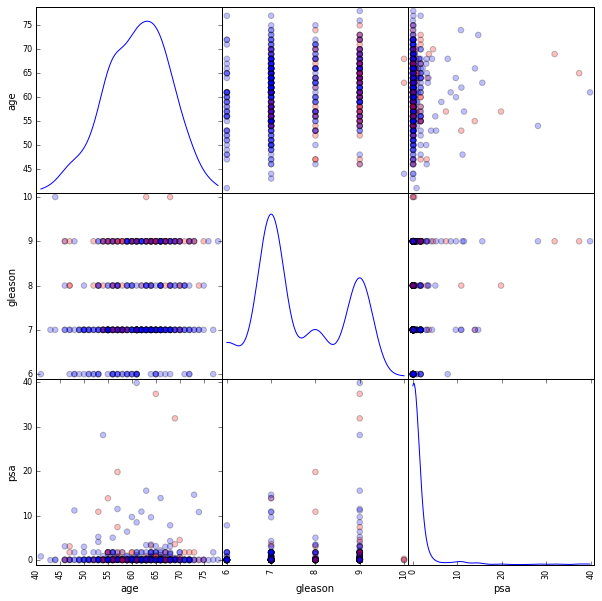

In [18]:
gleason = clinical['gleasonscore']
age = pd.to_numeric(clinical['yearstobirth'], errors = 'coerce')
age.fillna(value = np.mean(age), inplace=True)
psa = pd.to_numeric(clinical['psavalue'], errors= 'coerce')
psa.fillna(value = np.mean(psa), inplace =True)
gleason = gleason.loc[y.index]

benchmarkDF = pd.DataFrame({'gleason': gleason,
                            'age':age ,
                            'psa' : psa,
                            'y' : y}, index=X.index)

sm = pd.scatter_matrix(benchmarkDF, 
                       alpha=0.25, 
                       figsize= (10,10), 
                       diagonal = 'kde', 
                       c = benchmarkDF['y'].replace({'n1': 'red','n0':'blue'}), 
                       s = 125)

plt.savefig("Figures/clin_scatter_matrix.png")

In [19]:
benchmarkDF.drop(['y'], axis=1, inplace = True)


In [20]:
benchmarkDF = benchmarkDF.reindex(y.index)

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
from sklearn.model_selection import train_test_split

train_k = round(len(y)*0.80)
test_k = len(y) - train_k
seed = 123
folds = 4

In [23]:
benchmark_train, benchmark_test, bench_y_train, bench_y_test = train_test_split(benchmarkDF, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = seed,
                                                    stratify = y)

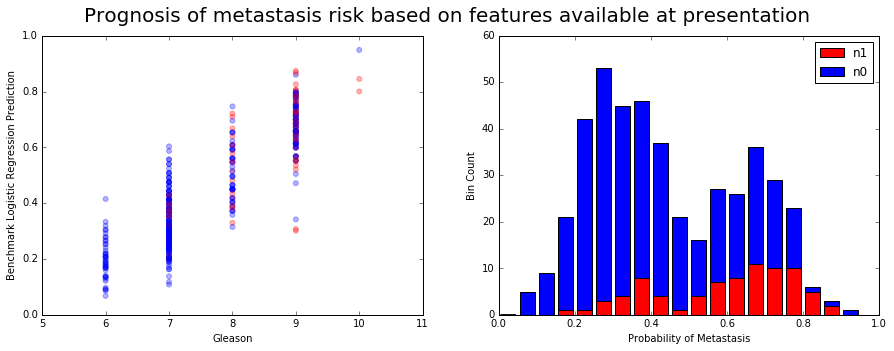

In [24]:
clf_LR_bm = LogisticRegression(penalty='l2',
                              dual=False,
                              tol=0.0001,
                              C=1,
                              fit_intercept=True,
                              intercept_scaling=1,
                              class_weight='balanced',
                              random_state=123,
                              solver='liblinear',
                              max_iter=100,
                              multi_class='ovr',
                              verbose=0,
                              warm_start=False,
                              n_jobs=1)

clf_LR_bm.fit(benchmark_train, bench_y_train)  #use training set for model learning

bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(benchmarkDF['gleason'], clf_LR_bm.predict_proba(benchmarkDF)[:,1], 
          color = y.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.3,
          s = 25)
A.set_ylabel('Benchmark Logistic Regression Prediction')
A.set_xlabel('Gleason')
plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

groups = [clf_LR_bm.predict_proba(benchmarkDF.loc[y[y=='n1'].index, :])[:,1], 
          clf_LR_bm.predict_proba(benchmarkDF.loc[y[y=='n0'].index, :])[:,1]]
bins = np.arange(0,1,0.05)
B.hist(groups, label =['n1', 'n0'],  bins = bins, color = ['red','blue'], stacked = True)
B.set_xlabel('Probability of Metastasis')
B.set_ylabel('Bin Count')
A.set_ylim(0,1)
B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show
bench_fig.savefig('Figures/benchmark.png')

In [25]:
print(benchmarkDF.columns)
clf_LR_bm.coef_

Index(['age', 'gleason', 'psa'], dtype='object')


array([[-0.06416004,  0.8575895 , -0.04111315]])

In [26]:
"Benchmark Performance on Test dataset"
print(clf_LR_bm)
print('\nNull F beta: ', fbeta_score(bench_y_test, clf_LR_bm.predict(benchmark_test), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(bench_y_test, clf_LR_bm.predict(benchmark_test)),"\n")
print(classification_report(bench_y_test, clf_LR_bm.predict(benchmark_test), labels = ['n0','n1']))
print('\nLogLoss: ', log_loss(bench_y_test.replace({'n0':0, 'n1':1}), 
         clf_LR_bm.predict_proba(benchmark_test)[:,1]))

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Null F beta:  0.597826086957

MCC:  0.375949201307 

             precision    recall  f1-score   support

         n0       0.92      0.77      0.84        73
         n1       0.39      0.69      0.50        16

avg / total       0.82      0.75      0.78        89


LogLoss:  0.567450424342


## Feature Reduction
### Gini Importance Filter

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf_RF = RandomForestClassifier(n_estimators=1000, 
                                criterion='gini', 
                                max_depth=3, 
                                min_samples_split=30, 
                                min_samples_leaf=5, 
                                min_weight_fraction_leaf=0.0, 
                                max_features= 'auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=1, 
                                random_state=seed, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight='balanced')


In [29]:
clf_RF.fit(X, y)
Gini_DF = pd.DataFrame({'Gini' :clf_RF.feature_importances_}, index=X.columns).sort_values(by = ['Gini'], axis = 0, ascending = False)
#Gini_DF.reset_index(inplace=True)
print(Gini_DF.head())

              Gini
EDN3      0.004070
GNE       0.003262
NRP1      0.003229
ZNF263    0.003218
KRTAP5.1  0.003190


In [30]:
"""Set k number of genes to retain"""
k = 20

In [31]:
X = X.loc[:,Gini_DF.iloc[0:k].index]

## Scale X to Xs

In [32]:

from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index = X.index)


## PCA Transformation

In [34]:
from sklearn.decomposition import PCA
components = 2

In [35]:
pca = PCA(n_components = components, whiten=False)
pca.fit(Xs)
Xpc = pd.DataFrame(pca.transform(Xs), columns = range(0,components,1), index = X.index)

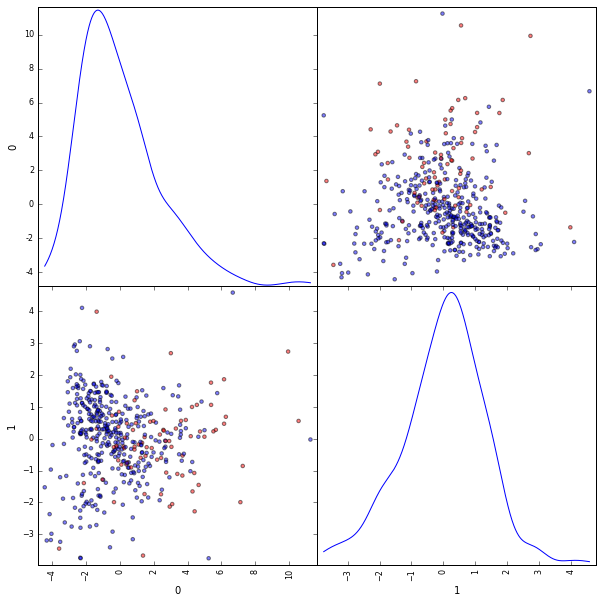

In [36]:
sm = pd.scatter_matrix(Xpc, 
                       alpha=0.5, 
                       figsize= (10,10), 
                       diagonal = 'kde', 
                       c = y.replace({'n1': 'red','n0':'blue'}), 
                       s = 50)
plt.savefig("Figures/PC_components_scatter_matrix.png")

In [37]:
%run -i 'support files/renders_PCA.py'

,Explained Variance,EDN3,GNE,NRP1,ZNF263,KRTAP5.1,ZNRF3,UBE2D2,LGI3,SF3B2,...,ABCC5,C9orf25,NVL,TTC9C,MAP6D1,SPAG1,LOC440944,FKBP15,IRF5,RNF19A
Dimension 1,0.2799,-0.0792,-0.1541,0.2005,0.2322,0.2207,-0.1140,0.2185,-0.1302,0.2154,...,0.2789,0.2478,0.2251,0.2535,0.2057,0.2633,0.2578,0.2398,0.2227,0.3108
Dimension 2,0.0846,0.1239,0.4293,0.1016,-0.2882,-0.1197,0.5169,-0.1227,0.0200,0.1170,...,0.1013,0.2095,0.0144,0.1903,-0.1147,0.0641,-0.1043,0.4543,-0.0069,0.1832


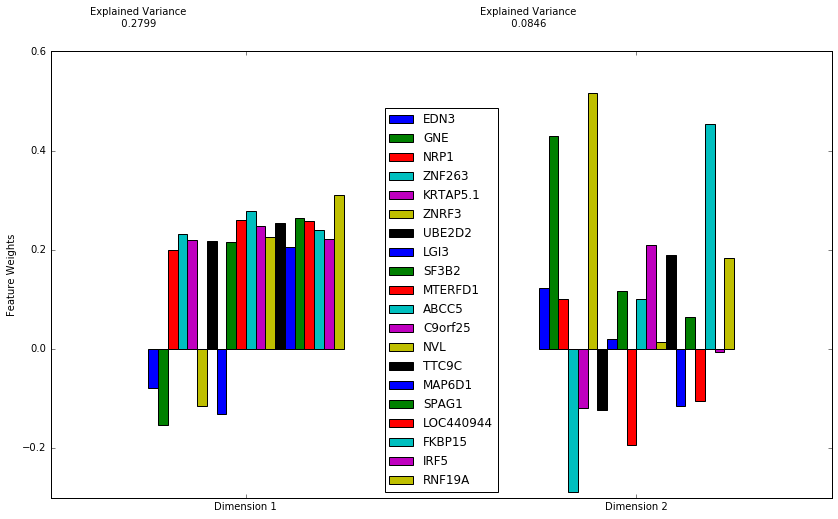

In [38]:
pca_results(Xs, pca)

### Test Train Split

In [39]:

X_train, X_test, y_train, y_test = train_test_split(Xpc, y, 
                                                    test_size= test_k, 
                                                    train_size = train_k,
                                                    random_state = seed,
                                                    stratify = y)

## LR with GridSearch

In [40]:
from sklearn.linear_model import LogisticRegressionCV

In [41]:

clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [42]:
clf_LR.C_

array([ 10000.])

In [43]:
"Benchmark Performance on Test dataset"
print(clf_LR)
print('\nNull F beta: ', fbeta_score(y_test, clf_LR.predict(X_test), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf_LR.predict(X_test)),"\n")
print(classification_report(y_test, clf_LR.predict(X_test), labels = ['n0','n1']))
print('\nLogLoss: ', log_loss(y_test.replace({'n0':0, 'n1':1}), 
         clf_LR.predict_proba(X_test)[:,1]))

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

Null F beta:  0.744680851064

MCC:  0.532746634771 

             precision    recall  f1-score   support

         n0       0.97      0.78      0.86        73
         n1       0.47      0.88      0.61        16

avg / total       0.88      0.80      0.82        89


LogLoss:  0.527981544815


In [44]:
clf_LR.coef_

array([[ 0.55253764, -0.21878498]])

## LR for Gleason + PC_0

In [45]:
X_2f = pd.DataFrame({'PC_0': Xpc.loc[:,0], 'gleason': benchmarkDF.loc[:,'gleason']}, index=Xpc.index)
X_2f.shape

(446, 2)

In [46]:
X_3f = Xpc.join(benchmarkDF.loc[:,'gleason'])
X_3f.shape

(446, 3)

## 2 Features

In [47]:
X_train = X_2f.loc[X_train.index,:]
X_test = X_2f.loc[X_test.index,:]

In [48]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

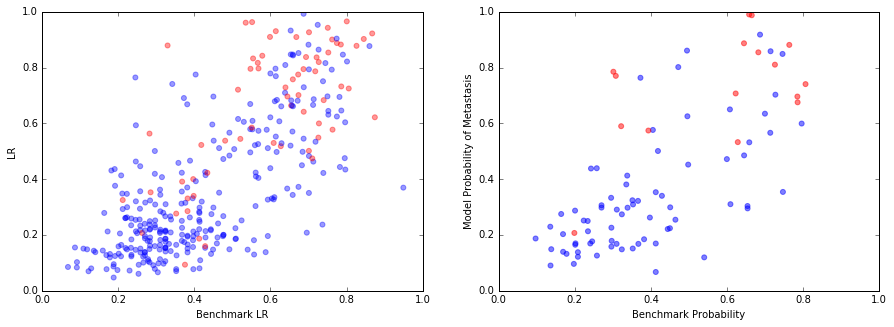

In [49]:
bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(clf_LR_bm.predict_proba(benchmarkDF.loc[X_train.index,:])[:,1],
          clf_LR.predict_proba(X_train)[:,1],
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.4,
          s = 25)
A.set_ylabel('LR')
A.set_xlabel('Benchmark LR')
#plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

B.scatter(clf_LR_bm.predict_proba(benchmarkDF.loc[X_test.index,:])[:,1],
          clf_LR.predict_proba(X_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
A.set_ylim(0,1)
A.set_xlim(0,1)
B.set_ylabel('Model Probability of Metastasis')
B.set_xlabel('Benchmark Probability')
B.set_ylim(0,1)
B.set_xlim(0,1)
#B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show
bench_fig.savefig('Figures/model_benchmark_comparison_train_test.png')

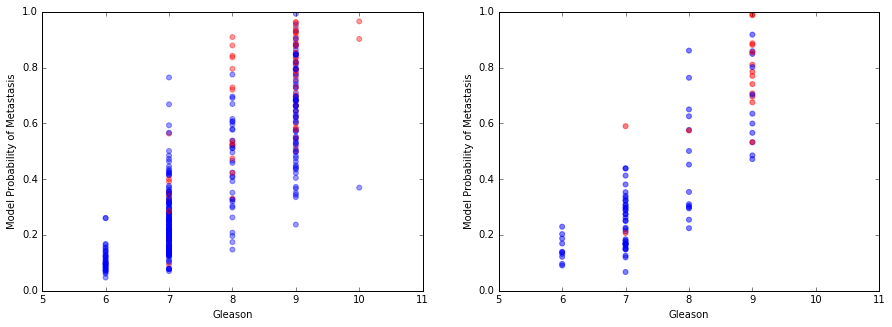

In [50]:
bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(benchmarkDF.loc[X_train.index,'gleason'],
          clf_LR.predict_proba(X_train)[:,1],
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.4,
          s = 25)
A.set_xlabel('Gleason')
A.set_ylabel('Model Probability of Metastasis')
#plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

B.scatter(benchmarkDF.loc[X_test.index,'gleason'],
          clf_LR.predict_proba(X_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
A.set_ylim(0,1)
#A.set_xlim(0,1)
B.set_ylabel('Model Probability of Metastasis')
B.set_xlabel('Gleason')
B.set_ylim(0,1)
B.set_xlim(5,11)
#B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show
bench_fig.savefig('Figures/gleason_model_prob.png')

In [51]:

print(clf_LR)
print('\nF beta: ', fbeta_score(y_test, clf_LR.predict(X_test), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf_LR.predict(X_test)),"\n")
print(classification_report(y_test, clf_LR.predict(X_test), labels = ['n0','n1']))
print('\nLogLoss: ', log_loss(y_test.replace({'n0':0, 'n1':1}), 
         clf_LR.predict_proba(X_test)[:,1]))

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

F beta:  0.797872340426

MCC:  0.594645395207 

             precision    recall  f1-score   support

         n0       0.98      0.79      0.88        73
         n1       0.50      0.94      0.65        16

avg / total       0.90      0.82      0.84        89


LogLoss:  0.478869458999


In [52]:
clf_LR.coef_

array([[ 0.4202307 ,  0.49248885]])

In [53]:
X_train.columns

Index(['PC_0', 'gleason'], dtype='object')

In [54]:
clf_LR.C_

array([ 21.5443469])

## 3 Features

In [55]:
X_train = X_3f.loc[X_train.index,:]
X_test = X_3f.loc[X_test.index,:]

In [56]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

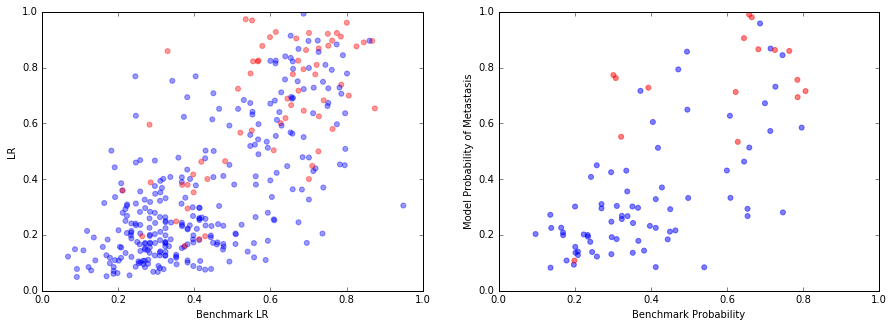

In [57]:
bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(clf_LR_bm.predict_proba(benchmarkDF.loc[X_train.index,:])[:,1],
          clf_LR.predict_proba(X_train)[:,1],
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.4,
          s = 25)
A.set_ylabel('LR')
A.set_xlabel('Benchmark LR')
#plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

B.scatter(clf_LR_bm.predict_proba(benchmarkDF.loc[X_test.index,:])[:,1],
          clf_LR.predict_proba(X_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
A.set_ylim(0,1)
A.set_xlim(0,1)
B.set_ylabel('Model Probability of Metastasis')
B.set_xlabel('Benchmark Probability')
B.set_ylim(0,1)
B.set_xlim(0,1)
#B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show
bench_fig.savefig('Figures/model_benchmark_comparison_train_test.png')

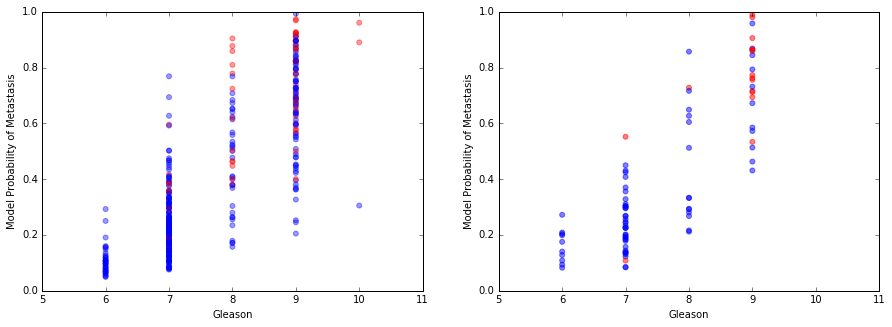

In [58]:
bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(benchmarkDF.loc[X_train.index,'gleason'],
          clf_LR.predict_proba(X_train)[:,1],
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.4,
          s = 25)
A.set_xlabel('Gleason')
A.set_ylabel('Model Probability of Metastasis')
#plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

B.scatter(benchmarkDF.loc[X_test.index,'gleason'],
          clf_LR.predict_proba(X_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
A.set_ylim(0,1)
#A.set_xlim(0,1)
B.set_ylabel('Model Probability of Metastasis')
B.set_xlabel('Gleason')
B.set_ylim(0,1)
B.set_xlim(5,11)
#B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show
bench_fig.savefig('Figures/gleason_model_prob.png')

In [59]:

print(clf_LR)
print('\nF beta: ', fbeta_score(y_test, clf_LR.predict(X_test), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf_LR.predict(X_test)),"\n")
print(classification_report(y_test, clf_LR.predict(X_test), labels = ['n0','n1']))
print('\nLogLoss: ', log_loss(y_test.replace({'n0':0, 'n1':1}), 
         clf_LR.predict_proba(X_test)[:,1]))

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

F beta:  0.797872340426

MCC:  0.594645395207 

             precision    recall  f1-score   support

         n0       0.98      0.79      0.88        73
         n1       0.50      0.94      0.65        16

avg / total       0.90      0.82      0.84        89


LogLoss:  0.484352951072


In [60]:
clf_LR.coef_

array([[ 0.42829135, -0.18933334,  0.47498658]])

In [61]:
X_train.columns

Index([0, 1, 'gleason'], dtype='object')

In [62]:
clf_LR

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [63]:
clf_LR.C_

array([ 21.5443469])

## LDA exploration

In [64]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [65]:
lda = LinearDiscriminantAnalysis(solver='svd', 
                                 shrinkage=None, 
                                 priors=None, 
                                 n_components=1, 
                                 store_covariance=False, 
                                 tol=0.0001)

In [66]:
lda.fit(Xs.loc[X_train.index,:], y_train)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [67]:
Xlda = pd.DataFrame({'LDA' : lda.transform(Xs).reshape(1,-1)[0], 'gleason': benchmarkDF.loc[:,'gleason']}, index=Xs.index)

In [68]:
X_train = Xlda.loc[X_train.index,:]
X_test = Xlda.loc[X_test.index,:]

In [69]:
clf_LR = LogisticRegressionCV(Cs=10, 
                              fit_intercept=True, 
                              cv=folds, 
                              dual=False, 
                              penalty='l2', 
                              scoring='log_loss', 
                              solver='liblinear', 
                              tol=0.0001, 
                              max_iter=100, 
                              class_weight='balanced', 
                              n_jobs=1, 
                              verbose=0, 
                              refit=True, 
                              intercept_scaling=1.0, 
                              multi_class='ovr', 
                              random_state=seed)
clf_LR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

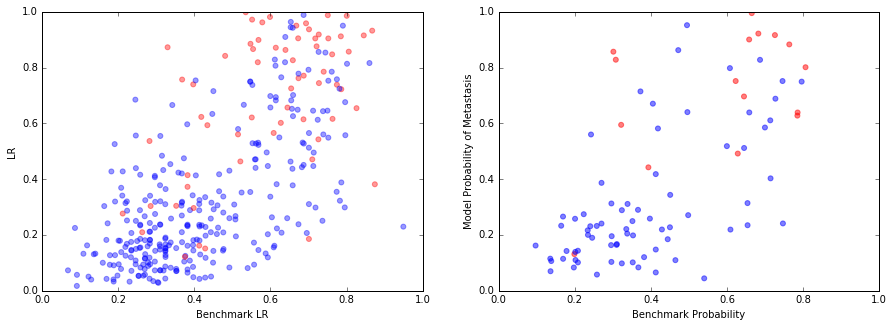

In [70]:
bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(clf_LR_bm.predict_proba(benchmarkDF.loc[X_train.index,:])[:,1],
          clf_LR.predict_proba(X_train)[:,1],
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.4,
          s = 25)
A.set_ylabel('LR')
A.set_xlabel('Benchmark LR')
#plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

B.scatter(clf_LR_bm.predict_proba(benchmarkDF.loc[X_test.index,:])[:,1],
          clf_LR.predict_proba(X_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
A.set_ylim(0,1)
A.set_xlim(0,1)
B.set_ylabel('Model Probability of Metastasis')
B.set_xlabel('Benchmark Probability')
B.set_ylim(0,1)
B.set_xlim(0,1)
#B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show
bench_fig.savefig('Figures/model_benchmark_comparison_train_test.png')

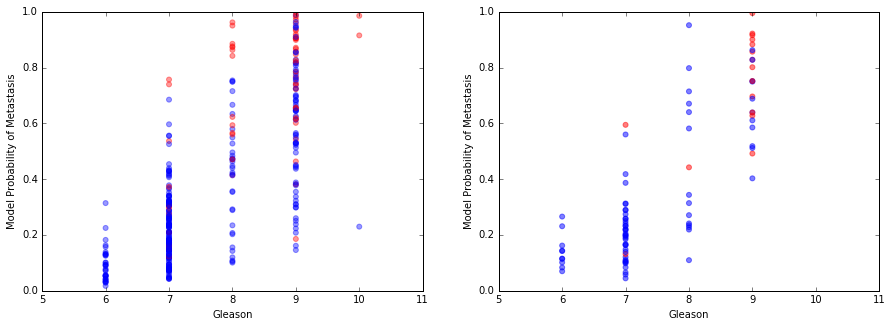

In [71]:
bench_fig = plt.figure(figsize=(15,5))
A= bench_fig.add_subplot(1,2,1)
B = bench_fig.add_subplot(1,2,2)
A.scatter(benchmarkDF.loc[X_train.index,'gleason'],
          clf_LR.predict_proba(X_train)[:,1],
          color = y_train.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.4,
          s = 25)
A.set_xlabel('Gleason')
A.set_ylabel('Model Probability of Metastasis')
#plt.suptitle('Prognosis of metastasis risk based on features available at presentation', fontsize=20)

B.scatter(benchmarkDF.loc[X_test.index,'gleason'],
          clf_LR.predict_proba(X_test)[:,1],
          color = y_test.replace({'n1':'red', 'n0': 'blue', 'NaN':'grey'}),
          alpha = 0.5,
          s = 25)
A.set_ylim(0,1)
#A.set_xlim(0,1)
B.set_ylabel('Model Probability of Metastasis')
B.set_xlabel('Gleason')
B.set_ylim(0,1)
B.set_xlim(5,11)
#B.legend()
#bench_fig.title("Prediction of Metastasis")
plt.show
bench_fig.savefig('Figures/gleason_model_prob.png')

In [72]:

print(clf_LR)
print('\nF beta: ', fbeta_score(y_test, clf_LR.predict(X_test), pos_label='n1',beta=2))
print('\nMCC: ',matthews_corrcoef(y_test, clf_LR.predict(X_test)),"\n")
print(classification_report(y_test, clf_LR.predict(X_test), labels = ['n0','n1']))
print('\nLogLoss: ', log_loss(y_test.replace({'n0':0, 'n1':1}), 
         clf_LR.predict_proba(X_test)[:,1]))

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

F beta:  0.691489361702

MCC:  0.470847874334 

             precision    recall  f1-score   support

         n0       0.95      0.77      0.85        73
         n1       0.43      0.81      0.57        16

avg / total       0.86      0.78      0.80        89


LogLoss:  0.460498591955


In [73]:
clf_LR.coef_

array([[ 1.10586511,  0.48675178]])

In [74]:
X_train.columns

Index(['LDA', 'gleason'], dtype='object')

In [75]:
clf_LR

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=123,
           refit=True, scoring='log_loss', solver='liblinear', tol=0.0001,
           verbose=0)

In [76]:
clf_LR.C_

array([ 21.5443469])